# Portfolio VaR Calculation and Correlation Monitoring
**Bartłomiej Jamiolkowski 18.01.2022**

# 1. Introduction

The aim of the work is to present the methods of monitoring the correlation along with the interpretation and to determine the VaR for the portfolio using specific methods. The calculations use the return prices of 3 well-known world stock exchange indexes (time period from 01/01/2006 to 31/12/2021) downloaded from the website stooq.pl. The project is implemented using the R language in Jupyter Notebook.

In [5]:
options(warn=-1)
library(SciViews)
library(ggplot2)
library(dplyr)
library(gridExtra)

library(fImport)
library(tseries)
library(quantmod)
library(GGally)
library(GAS)
library(segMGarch)
library(kableExtra)
library(tidyr)

Data import

In [37]:
nasdaq_d <- read.csv("^NDQ.csv", header = TRUE)
nikkei_225_d <- read.csv("^NKX.csv", header = TRUE)
shanghai_d <- read.csv("^SHC.csv", header = TRUE)

Choice of closing prices of stock indices

In [8]:
nasdaq_d_close <- nasdaq_d$Close
nikkei_225_d_close <- nikkei_225_d$Close
shanghai_d_close <- shanghai_d$Close

Calculation of logarithmic rates of return for individual indexes

In [9]:
rate_of_return_nasdaq <- rep(0, 4028)
for(i in 1:4028){
  rate_of_return_nasdaq[i] = 100 * log(nasdaq_d_close[i + 1]/nasdaq_d_close[i])
}

rate_of_return_nikkei_225 <- rep(0, 3917)
for(i in 1:3917){
  rate_of_return_nikkei_225[i] = 100 * log(nikkei_225_d_close[i + 1]/nikkei_225_d_close[i])
}

rate_of_return_shanghai <- rep(0, 3888)
for(i in 1:3888){
  rate_of_return_shanghai[i] = 100 * log(shanghai_d_close[i + 1]/shanghai_d_close[i])
}

## 1.1 Extraction of negative returns

Due to the visualization of changes in the correlation value over time, at this stage of the extraction negative rates of return with assigned dates are subject. Data is stored in created data frames for each index.

### 1.1.1 Negative Nasdaq Composite index returns

In [10]:
data1 <- data.frame(
  Date = nasdaq_d$Date[-1],
  Return = rate_of_return_nasdaq
)
minus_date <- c()
minus_return <- c()
for(i in 1:length(data1$Return)){
  if(data1$Return[i] < 0){
    minus_date <- append(minus_date, data1$Date[i])
    minus_return <-append(minus_return, data1$Return[i])
  }
}
data1 <- data.frame(
  Date = as.Date(minus_date),
  Return = minus_return
)

### 1.1.2 Negative rates of return for the Nikkei 225 index

In [12]:
data2 <- data.frame(
  Date = nikkei_225_d$Date[-1],
  Return = rate_of_return_nikkei_225
)
minus_date <- c()
minus_return <- c()
for(i in 1:length(data2$Return)){
  if(data2$Return[i] < 0){
    minus_date <- append(minus_date, data2$Date[i])
    minus_return <-append(minus_return, data2$Return[i])
  }
}
data2 <- data.frame(
  Date = as.Date(minus_date),
  Return = minus_return
)

### 1.1.3 Negative Shanghai Composite index returns

In [16]:
data3 <- data.frame(
  Date = shanghai_d$Date[-1],
  Return = rate_of_return_shanghai
)
minus_date <- c()
minus_return <- c()
for(i in 1:length(data3$Return)){
  if(data3$Return[i] < 0){
    minus_date <- append(minus_date, data3$Date[i])
    minus_return <-append(minus_return, data3$Return[i])
  }
}
data3 <- data.frame(
  Date = as.Date(minus_date),
  Return = minus_return
)

## 1.2 Transforming data to correlate

In order to calculate the correlation, the vectors should be aligned to the same length. In addition, the time data needed for the subsequent visualization of changes in the correlation value should be taken into account. Therefore, the most sensible solution is to choose the time span for the longest vector. Based on this vector, 3 new data frames are created. In each frame, the dates are assigned negative phrases searched for based on the dates in the previous 3 frames. As a result, a negative return column appears with NA values ​​present. NA values ​​arise as a result of two events. The first reason is the non-negative rate of return not included. The second reason for this is, for example, the lack of data from stock exchanges, for example in Asia, due to their closing on a certain day for various reasons. Two methods of solving the NA problem in time series are popular. The first way is to delete the row. The second, and in this case better way, is to replace the missing values ​​with the top or bottom values. The result of these operations is 3 vectors capable of calculating the correlation.

**negative returns on the Nasdaq Composite Index**

In [26]:
nasdaq <- data.frame(
  Date = nasdaq_d$Date[6:4029],
  Return = rep(NA, length(nasdaq_d$Close[6:4029]))
)
for(i in 1:length(nasdaq$Date)){
  for(j in 1:length(data1$Date)){
    if(nasdaq$Date[i] == data1$Date[j]){
      nasdaq$Return[i] = data1$Return[j]
    }
  }
}
minus_nasdaq <- nasdaq %>% fill(Return, .direction = 'downup')

**negative returns on the Nikkei 225 index**

In [18]:
nikkei_225 <- data.frame(
  Date = nasdaq$Date,
  Return = rep(0, 4024)
)
for(i in 1:length(nikkei_225$Date)){
  for(j in 1:length(data2$Date)){
    if(nikkei_225$Date[i] == data2$Date[j]){
      nikkei_225$Return[i] = data2$Return[j]
    }
  }
}
minus_nikkei_225 <- nikkei_225 %>% fill(Return, .direction = 'downup')

**negative returns of the Shanghai Composite index**

In [19]:
shanghai <- data.frame(
  Date = nasdaq$Date,
  Return = rep(0, 4024)
)
for(i in 1:length(shanghai$Date)){
  for(j in 1:length(data3$Date)){
    if(shanghai$Date[i] == data3$Date[j]){
      shanghai$Return[i] = data3$Return[j]
    }
  }
}
minus_shanghai <- shanghai %>% fill(Return, .direction = 'downup')

# 2. Monitoring the correlation

As part of the correlation monitoring, the correlations are calculated using: a rolling observation window (T = 30) with the use of Pearson's correlation, EWMA with lambda = 0.94 and GARCH (1.1). For this purpose, three functions are created to automate these processes. The effects of the algorithms' work are presented in the diagrams of the correlation of negative returns of three indices in the project.

**Pearson correlation (T = 30)**

In [20]:
pearson_corr <- function(x, y){
  p_cor <- c()
  for(i in 0:(length(x) - 31)){
    x_cor <- rep(0, 30)
    y_cor <- rep(0, 30)
    for(j in 1:30){
      x_cor[j] = x[j + i]
      y_cor[j] = y[j + i]
    }
    c = cor(x_cor, y_cor, method = "pearson")
    p_cor <- append(p_cor, c)
  }
  return(p_cor)
}

**EWMA correlation**

In [21]:
ewma_corr <- function(x, y){
  lambda = 0.94
  covariance <- rep(0, length(x))
  covariance[1] = cov(x, y)
  for(i in 1:(length(x) - 1)){
    covariance[i + 1] = covariance[i] * lambda + (1 - lambda) * x[i] * y[i]
  }
  variance_x <- rep(0, length(x))
  variance_x[1] = var(x)
  for(i in 1:(length(x) - 1)){
    variance_x[i + 1] = variance_x[i] * lambda + (1 - lambda) * x[i]^2
  }
  variance_y <- rep(0, length(y))
  variance_y[1] = var(y)
  for(i in 1:(length(y) - 1)){
    variance_y[i + 1] = variance_y[i] * lambda + (1 - lambda) * y[i]^2
  }
  sd_x <- rep(0, length(variance_x))
  sd_y <- rep(0, length(variance_y))
  for(i in 1:length(variance_x)){
    sd_x[i] = sqrt(variance_x[i])
    sd_y[i] = sqrt(variance_y[i])
  }
  ewma_cor <- rep(0, length(x))
  for(i in 1:length(variance_x)){
    ewma_cor[i] = covariance[i] / (sd_x[i] * sd_y[i])
  }
  return(ewma_cor)
}

**correlation GARCH (1,1)**

In [22]:
garch_corr <- function(x, y){
  gamma = 0.02
  alpha = 0.15
  beta = 0.83
  long_run_vr = 0.00015
  covariance <- rep(0, length(x))
  covariance[1] = cov(x, y)
  for(i in 1:(length(x) - 1)){
    covariance[i + 1] = beta * covariance[i] + alpha * x[i] * y[i] + gamma * long_run_vr
  }
  variance_x <- rep(0, length(x))
  variance_x[1] = var(x)
  for(i in 1:(length(x) - 1)){
    variance_x[i + 1] = beta * variance_x[i] + alpha * x[i]^2 + gamma * long_run_vr
  }
  variance_y <- rep(0, length(y))
  variance_y[1] = var(y)
  for(i in 1:(length(y) - 1)){
    variance_y[i + 1] = beta * variance_y[i] + alpha * y[i]^2 + gamma * long_run_vr
  }
  sd_x <- rep(0, length(variance_x))
  sd_y <- rep(0, length(variance_y))
  for(i in 1:length(variance_x)){
    sd_x[i] = sqrt(variance_x[i])
    sd_y[i] = sqrt(variance_y[i])
  }
  garch_cor <- rep(0, length(x))
  for(i in 1:length(variance_x)){
    garch_cor[i] = covariance[i] / (sd_x[i] * sd_y[i])
  }
  return(garch_cor)
}

# 2.1 Nasdaq Composite - Nikkei 225 correlation

Vectors containing the calculated correlation values are created using 3 methods.

In [23]:
pearson_nasdaq_nikkei_corr <- pearson_corr(minus_nasdaq$Return, minus_nikkei_225$Return)
ewma_nasdaq_nikkei_corr <- ewma_corr(minus_nasdaq$Return, nikkei_225$Return)
garch_nasdaq_nikkei_corr <- garch_corr(minus_nasdaq$Return, minus_nikkei_225$Return)

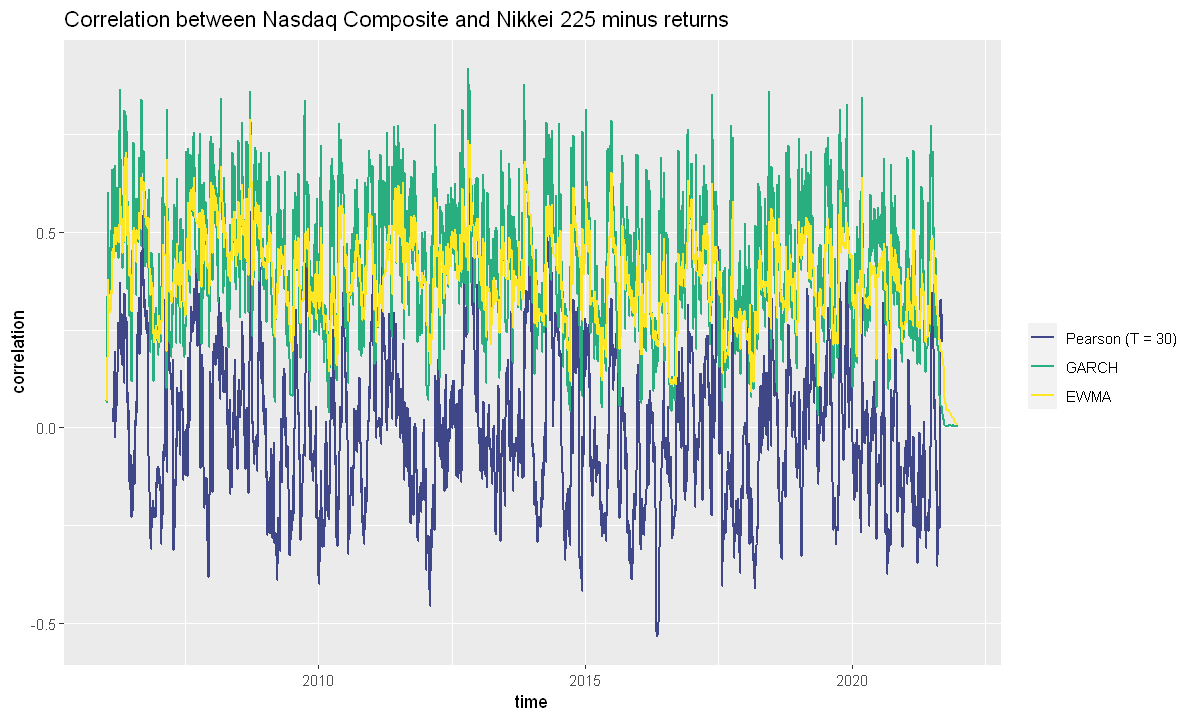

In [27]:
data4 <- data.frame(
  day = as.Date(nasdaq$Date),
  value1 = rep(NA, 4024),
  value2 = garch_nasdaq_nikkei_corr,
  value3 = ewma_nasdaq_nikkei_corr
)
for(i in 31:4024){
  data4$value1[i] = pearson_nasdaq_nikkei_corr[i - 30]
}

options(repr.plot.width=10, repr.plot.height=6)
ggplot(data = data4, aes(x = day, y = value1)) + 
geom_line(color = "#404788FF", size = 0.8) +
geom_line(aes(x = data4$day, y = data4$value2, color = '#29AF7FFF'), size = 0.8) +
geom_line(aes(x = data4$day, y = data4$value3, color = '#FDE725FF'), size = 0.8) +
ggtitle("Correlation between Nasdaq Composite and Nikkei 225 minus returns") +
ylab('correlation')+xlab('time') +
scale_colour_manual(name = '',values =c('#404788FF'='#404788FF', '#29AF7FFF'='#29AF7FFF','#FDE725FF'='#FDE725FF'), labels = c('Pearson (T = 30)', 'GARCH','EWMA'))

# 2.2 Nasdaq Composite - Shanghai Composite correlation

Vectors containing the calculated correlation values are created using 3 methods.

In [28]:
pearson_nasdaq_shanghai_corr <- pearson_corr(minus_nasdaq$Return, minus_shanghai$Return)
ewma_nasdaq_shanghai_corr <- ewma_corr(minus_nasdaq$Return, minus_shanghai$Return)
garch_nasdaq_shanghai_corr <- garch_corr(minus_nasdaq$Return, minus_shanghai$Return)

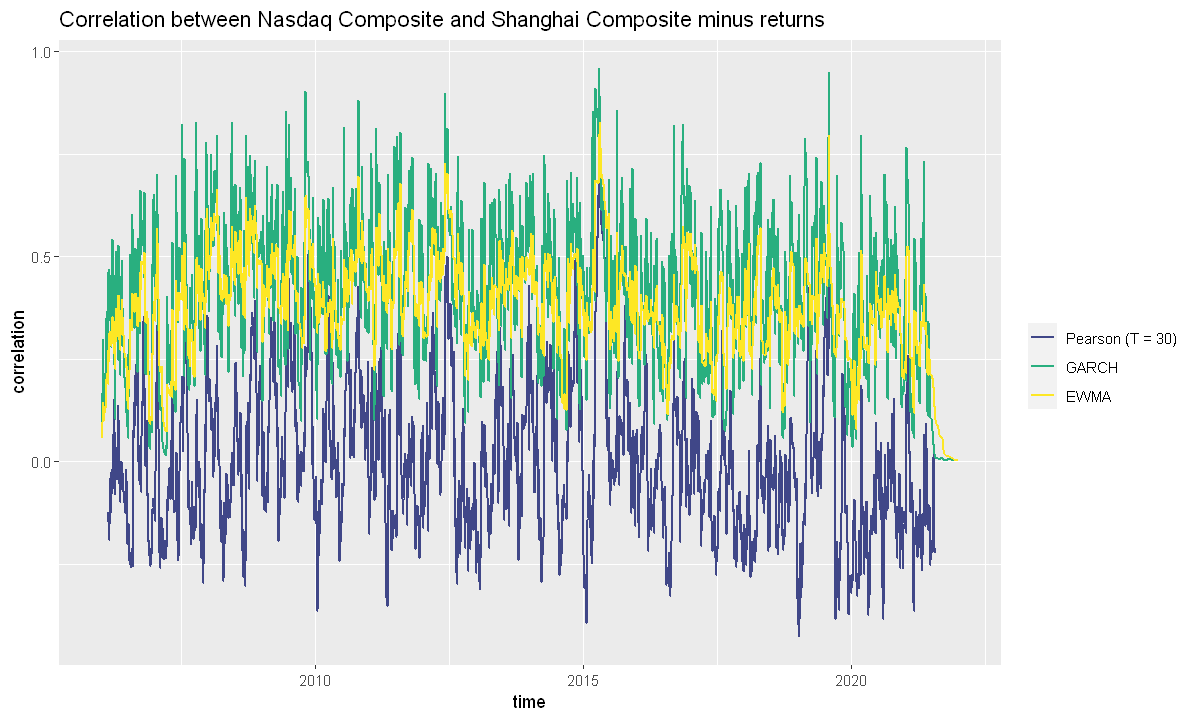

In [29]:
data5 <- data.frame(
  day = as.Date(nasdaq$Date),
  value1 = rep(NA, 4024),
  value2 = garch_nasdaq_shanghai_corr,
  value3 = ewma_nasdaq_shanghai_corr
)
for(i in 31:4024){
  data5$value1[i] = pearson_nasdaq_shanghai_corr[i - 30]
}
ggplot(data = data5, aes(x = day, y = value1)) + 
geom_line(color = "#404788FF", size = 0.8) +
geom_line(aes(x = data5$day, y = data5$value2, color = '#29AF7FFF'), size = 0.8) +
geom_line(aes(x = data5$day, y = data5$value3, color = '#FDE725FF'), size = 0.8) +
ggtitle("Correlation between Nasdaq Composite and Shanghai Composite minus returns") +
ylab('correlation')+xlab('time') +
scale_colour_manual(name = '',values =c('#404788FF'='#404788FF', '#29AF7FFF'='#29AF7FFF','#FDE725FF'='#FDE725FF'), labels = c('Pearson (T = 30)', 'GARCH', 'EWMA'))

# 2.3 Nikkei 225 correlation - Shanghai Composite

Vectors containing the calculated correlation values are created using 3 methods.

In [30]:
pearson_nikkei_225_shanghai_corr <- pearson_corr(minus_nikkei_225$Return, minus_shanghai$Return)
ewma_nikkei_225_shanghai_corr <- ewma_corr(minus_nikkei_225$Return, minus_shanghai$Return)
garch_nikkei_225_shanghai_corr <- garch_corr(minus_nikkei_225$Return, minus_shanghai$Return)

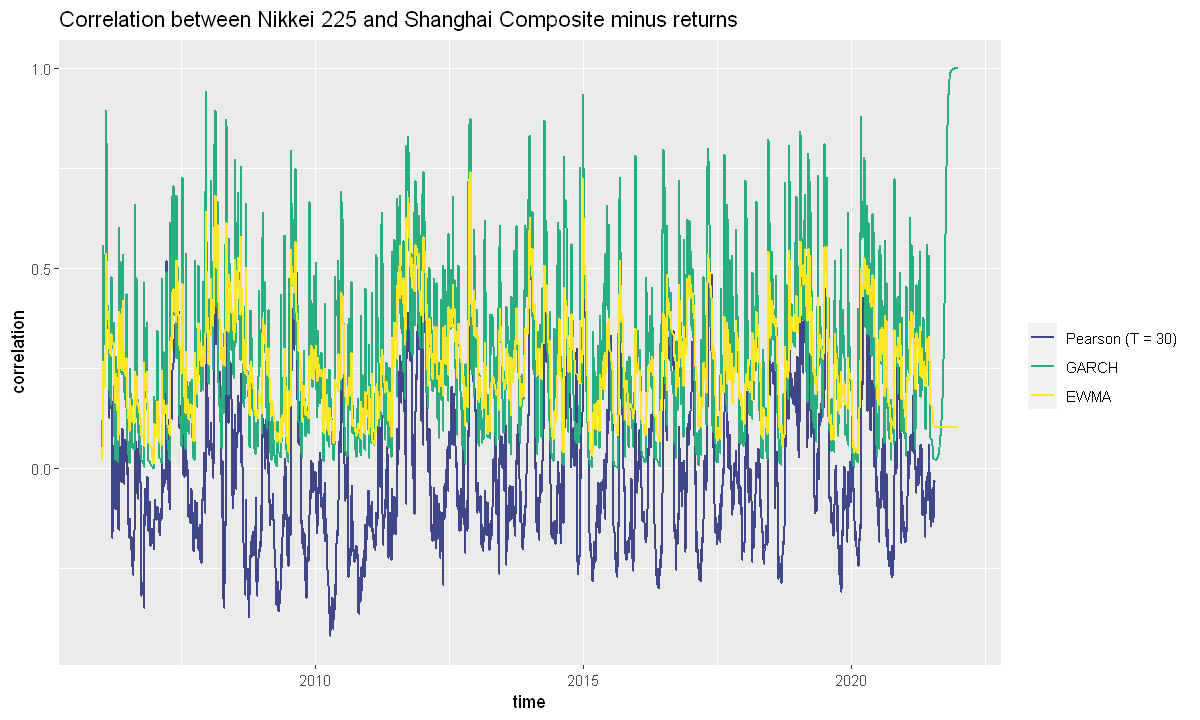

In [31]:
data6 <- data.frame(
  day = as.Date(nasdaq$Date),
  value1 = rep(NA, 4024),
  value2 = garch_nikkei_225_shanghai_corr,
  value3 = ewma_nikkei_225_shanghai_corr
)
for(i in 31:4024){
  data6$value1[i] = pearson_nikkei_225_shanghai_corr[i - 30]
}

ggplot(data = data6, aes(x = day, y = value1)) + 
geom_line(color = "#404788FF", size = 0.8) +
geom_line(aes(x = data6$day, y = data6$value2, color = '#29AF7FFF'), size = 0.8) +
geom_line(aes(x = data6$day, y = data6$value3, color = '#FDE725FF'), size = 0.8) +
ggtitle("Correlation between Nikkei 225 and Shanghai Composite minus returns") +
ylab('correlation')+xlab('time') +
scale_colour_manual(name = '',values =c('#404788FF'='#404788FF', '#29AF7FFF'='#29AF7FFF','#FDE725FF'='#FDE725FF'), labels = c('Pearson (T = 30)', 'GARCH', 'EWMA'))

**Interpretation**

The presented graphics show that the correlation for negative rates of return is not constant over time. Pearson's correlation indicates the lack of a strong linear relationship between the studied indices. EWMA and GARCH methods take higher positive values suggesting a stronger linear relationship. In this case, fluctuations in correlation may attract attention. The EWMA model is characterized by the smallest fluctuations.

# 3. Influence of the considered correlation between loss rates on risk reduction

Considering the correlation between loss rates can reduce VaR because the correlation provides information about the strength and direction of the relationship between financial instruments and industries.
This translates into a method of portfolio diversification and thus reduces the risk of losses. For example, if the portfolio consists of only aviation stocks (all eggs in the basket), then in the event of negative information from the aviation sector, stock prices will decrease and the portfolio will record a decrease in value. Therefore, the weakest possible correlations are desired, meaning that the portfolio manager has invested in a variety of industries, areas and companies.

# 4. Determining the VaR for the portfolio

This part of the project aims to present the calculated 95% VaR of a portfolio consisting of 3 selected indices using 2 correlation monitoring models: EWMA and GARCH with a 250-day history.

In this case, also create vectors of equal length in the same way as described in the section on monitoring correlations.

In [32]:
data7 <- data.frame(
  Date = nasdaq_d$Date[2:4029],
  Return = rate_of_return_nasdaq
)

In [35]:
data8 <- data.frame(
  Date = nasdaq_d$Date[2:4029],
  Return = rep(0, 4028)
)
for(i in 1:length(data1$Date)){
  for(j in 1:length(nikkei_225_d$Date)){
    if(data8$Date[i] == nikkei_225_d$Date[j]){
      data8$Return[i] = 1
    }
  }
}
j = 1
a = 1
for(i in 1:length(data2$Date)){
  if(data8$Return[i] == 1 && a == 1){
    data8$Return[i] = 0
    a = 0
  }
  if(data8$Return[i] == 1){
    data8$Return[i] = rate_of_return_nikkei_225[j]
    j = j + 1
  }
  else{
    data8$Return[i] = NA
  }
}
data8 <- data8 %>% fill(Return, .direction = 'downup')

In [40]:
data9 <- data.frame(
  Date = nasdaq_d$Date[2:4029],
  Return = rep(0, 4028)
)
for(i in 1:length(data1$Date)){
  for(j in 1:length(shanghai_d$Date)){
    if(data9$Date[i] == shanghai_d$Date[j]){
      data9$Return[i] = 1
    }
  }
}
j = 1
a = 1
for(i in 1:length(data3$Date)){
  if(data9$Return[i] == 1 && a == 1){
    data9$Return[i] = 0
    a = 0
  }
  if(data9$Return[i] == 1){
    data9$Return[i] = rate_of_return_shanghai[j]
    j = j + 1
  }
  else{
    data9$Return[i] = NA
  }
}
data9 <- data9 %>% fill(Return, .direction = 'downup')


# 4.1 EWMA method

In [41]:
ewma_var <- function(x, y, z, a){
  ewma_value_at_risk <- c()
  for(i in 0:(length(x) - 251)){
    window_x <- rep(0, 250)
    window_y <- rep(0, 250)
    window_z <- rep(0, 250)
    for(j in 1:250){
      window_x[j] = x[i + j]
      window_y[j] = y[i + j]
      window_z[j] = z[i + j]
    }
    lambda = 0.94
    variance_x <- rep(0, length(window_x))
    variance_y <- rep(0, length(window_y))
    variance_z <- rep(0, length(window_z))
    variance_x[1] = var(window_x)
    variance_y[1] = var(window_y)
    variance_z[1] = var(window_z)
    for(i in 1:(length(window_x) - 1)){
      variance_x[i + 1] = variance_x[i] * lambda + (1 - lambda) * window_x[i]^2
      variance_y[i + 1] = variance_y[i] * lambda + (1 - lambda) * window_y[i]^2
      variance_z[i + 1] = variance_z[i] * lambda + (1 - lambda) * window_z[i]^2
    }
    covariance_xy <- rep(0, length(window_x))
    covariance_xz <- rep(0, length(window_x))
    covariance_yz <- rep(0, length(window_x))
    covariance_xy[1] = cov(window_x, window_y)
    covariance_xz[1] = cov(window_x, window_z)
    covariance_yz[1] = cov(window_y, window_z)
    for(i in 1:(length(window_x) - 1)){
      covariance_xy[i + 1] = covariance_xy[i] * lambda + (1 - lambda) * window_x[i] * window_y[i]
      covariance_xz[i + 1] = covariance_xz[i] * lambda + (1 - lambda) * window_x[i] * window_z[i]
      covariance_yz[i + 1] = covariance_yz[i] * lambda + (1 - lambda) * window_y[i] * window_z[i]
    }
    correlation_xy = tail(covariance_xy, 1) / (sqrt(tail(variance_x, 1)) * sqrt(tail(variance_y, 1)))
    correlation_xz = tail(covariance_xz, 1) / (sqrt(tail(variance_x, 1)) * sqrt(tail(variance_z, 1)))
    correlation_yz = tail(covariance_yz, 1) / (sqrt(tail(variance_y, 1)) * sqrt(tail(variance_z, 1)))

    variance_portfolio = 1/9 * (tail(variance_x, 1) + tail(variance_y, 1) + tail(variance_z, 1))
    + 2/9 * (correlation_xy * sqrt(tail(variance_x, 1)) * sqrt(tail(variance_y, 1)) + correlation_xz              *  sqrt(tail(variance_x, 1)) * sqrt(tail(variance_z, 1)) + correlation_yz *
    sqrt(tail(variance_y, 1)) * sqrt(tail(variance_z, 1)))
    sd_portfolio = sqrt(variance_portfolio)
    q = qnorm(1 - a)
    value_var = sd_portfolio * q
    ewma_value_at_risk <- append(ewma_value_at_risk, value_var)
  }
  return(ewma_value_at_risk)
}

In [42]:
ewma_95_portfolio_var <- ewma_var(data7$Return, data8$Return, data9$Return, 0.05)

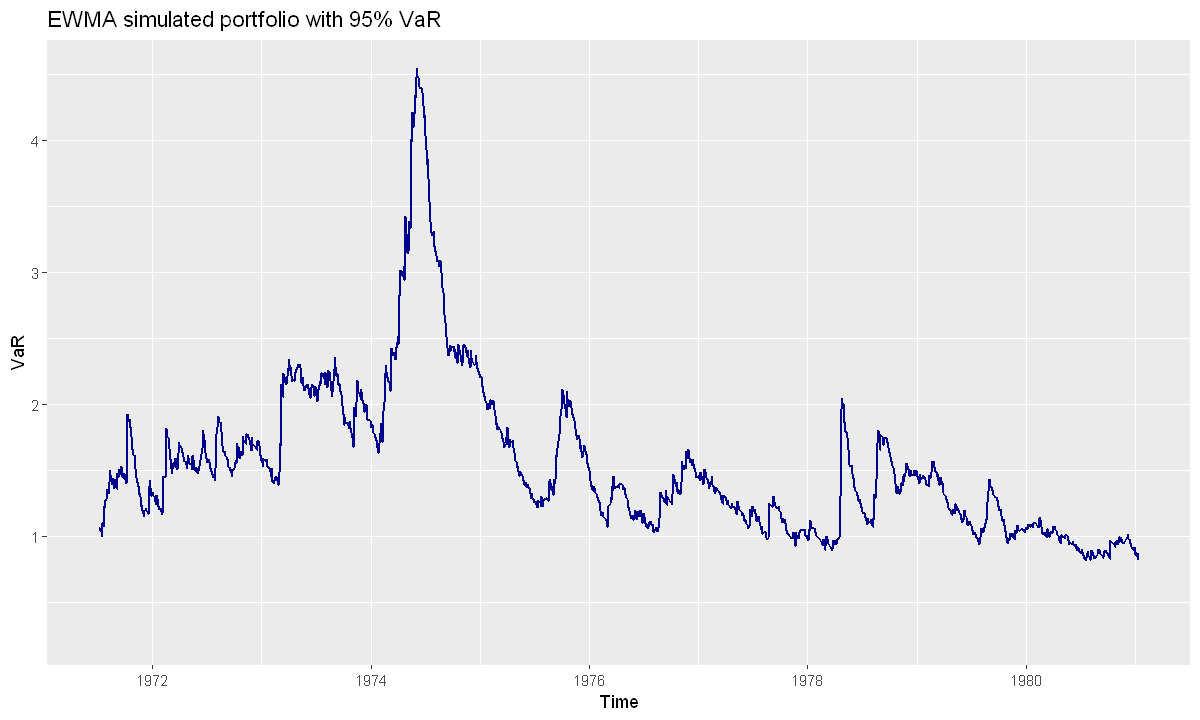

In [47]:
data11 <- data.frame(
  day = as.Date(data1$Date[251:4028]),
  value1 = ewma_95_portfolio_var
)

ggplot(data = data11, aes(x = day, y = value1)) + 
  geom_line(color = "darkblue", size = 0.8) +
  ggtitle("EWMA simulated portfolio with 95% VaR") +
  ylab('VaR')+xlab('Time')

# 4.2 GARCH method (1,1)

In [44]:
garch_var <- function(x, y, z, a){
  garch_value_at_risk <- c()
  for(i in 0:(length(x) - 251)){
    window_x <- rep(0, 250)
    window_y <- rep(0, 250)
    window_z <- rep(0, 250)
    for(j in 1:250){
      window_x[j] = x[i + j]
      window_y[j] = y[i + j]
      window_z[j] = z[i + j]
    }
    gamma = 0.02
    alpha = 0.15
    beta = 0.83
    long_run_vr = 0.00015
    variance_x <- rep(0, length(window_x))
    variance_y <- rep(0, length(window_y))
    variance_z <- rep(0, length(window_z))
    variance_x[1] = var(window_x)
    variance_y[1] = var(window_y)
    variance_z[1] = var(window_z)
    for(i in 1:(length(window_x) - 1)){
      variance_x[i + 1] = beta * variance_x[i] + alpha * window_x[i]^2 + gamma * long_run_vr
      variance_y[i + 1] = beta * variance_y[i] + alpha * window_y[i]^2 + gamma * long_run_vr
      variance_z[i + 1] = beta * variance_z[i] + alpha * window_z[i]^2 + gamma * long_run_vr
    }
    covariance_xy <- rep(0, length(window_x))
    covariance_xz <- rep(0, length(window_x))
    covariance_yz <- rep(0, length(window_x))
    covariance_xy[1] = cov(window_x, window_y)
    covariance_xz[1] = cov(window_x, window_z)
    covariance_yz[1] = cov(window_y, window_z)
    for(i in 1:(length(window_x) - 1)){
      covariance_xy[i + 1] = beta * covariance_xy[i] + alpha * window_x[i] * window_y[i] + gamma *                 long_run_vr
      covariance_xz[i + 1] = beta * covariance_xz[i] + alpha * window_x[i] * window_z[i] + gamma *                 long_run_vr
      covariance_yz[i + 1] = beta * covariance_yz[i] + alpha * window_y[i] * window_z[i] + gamma *                 long_run_vr
    }
    correlation_xy = tail(covariance_xy, 1) / (sqrt(tail(variance_x, 1)) * sqrt(tail(variance_y, 1)))
    correlation_xz = tail(covariance_xz, 1) / (sqrt(tail(variance_x, 1)) * sqrt(tail(variance_z, 1)))
    correlation_yz = tail(covariance_yz, 1) / (sqrt(tail(variance_y, 1)) * sqrt(tail(variance_z, 1)))

    variance_portfolio = 1/9 * (tail(variance_x, 1) + tail(variance_y, 1) + tail(variance_z, 1))
    + 2/9 * (correlation_xy * sqrt(tail(variance_x, 1)) * sqrt(tail(variance_y, 1)) + correlation_xz              *  sqrt(tail(variance_x, 1)) * sqrt(tail(variance_z, 1)) + correlation_yz *
    sqrt(tail(variance_y, 1)) * sqrt(tail(variance_z, 1)))
    sd_portfolio = sqrt(variance_portfolio)
    q = qnorm(1 - a)
    value_var = sd_portfolio * q
    garch_value_at_risk <- append(garch_value_at_risk, value_var)
  }
  return(garch_value_at_risk)
}

In [45]:
garch_95_portfolio_var <- garch_var(data7$Return, data8$Return, data9$Return, 0.05)

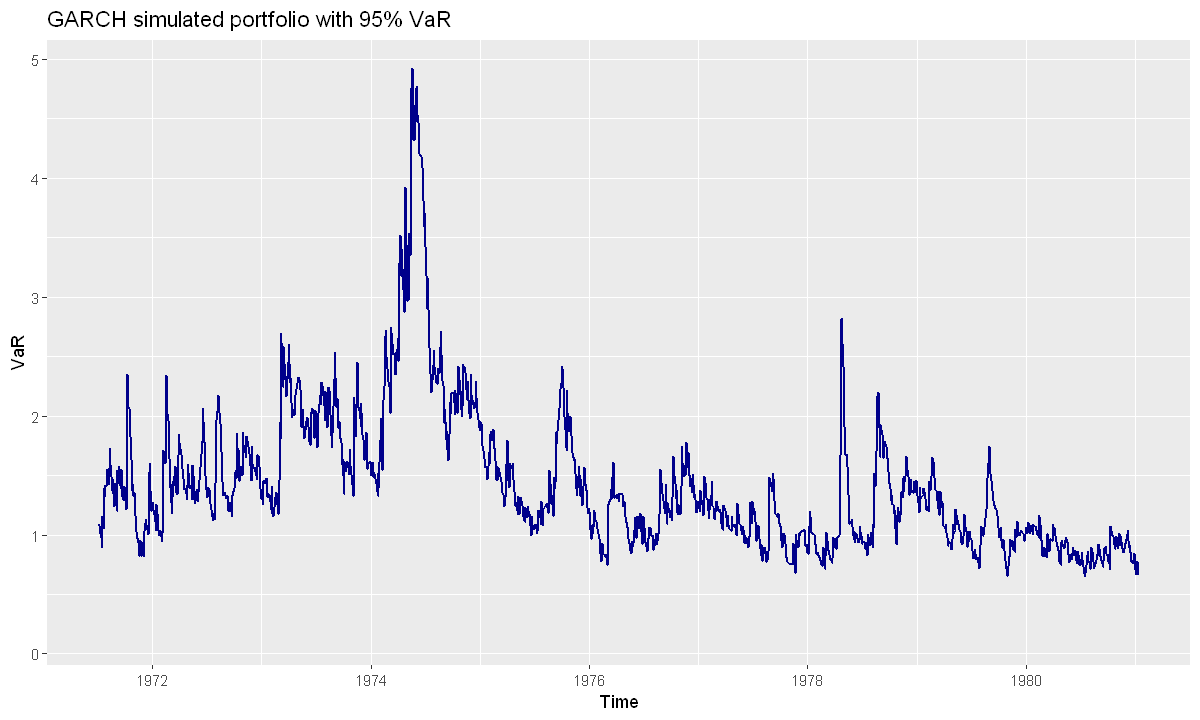

In [48]:
data12 <- data.frame(
  day = as.Date(data1$Date[251:4028]),
  value1 = garch_95_portfolio_var
)

ggplot(data = data12, aes(x = day, y = value1)) + 
  geom_line(color = "darkblue", size = 0.8) +
  ggtitle("GARCH simulated portfolio with 95% VaR") +
  ylab('VaR')+xlab('Time')

# 4.4 Comparison of methods

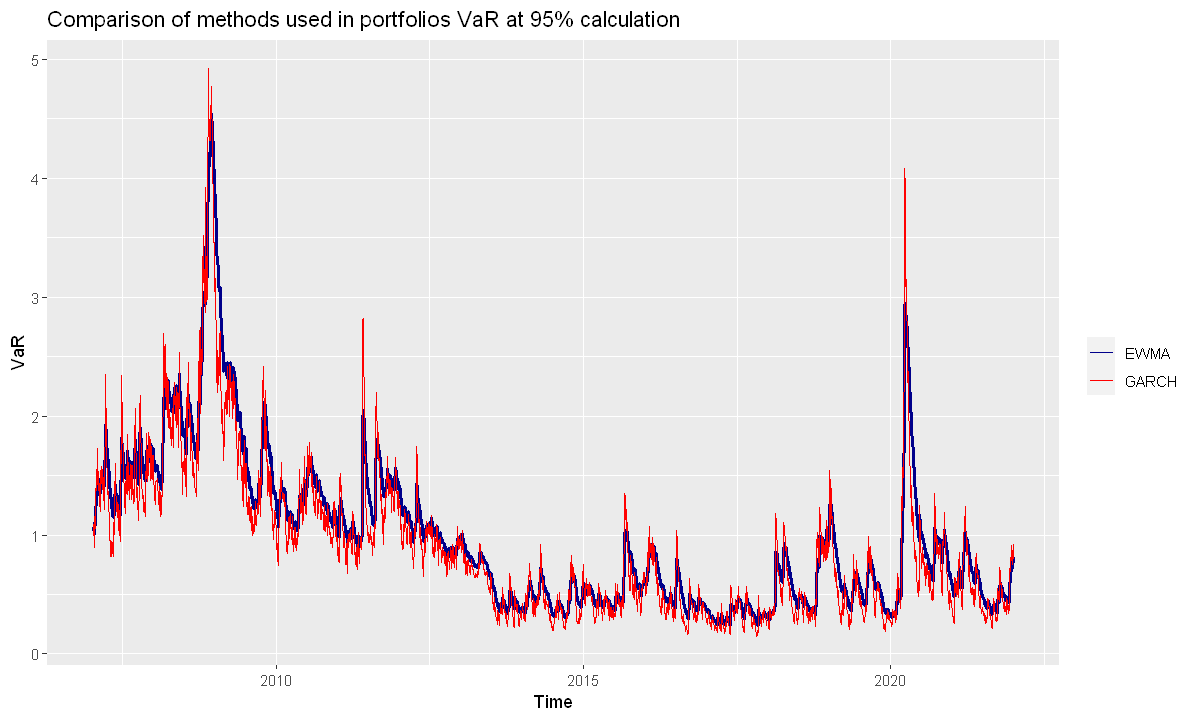

In [51]:
day = as.Date(shanghai$Date)

data13 <- data.frame(
  day = day[251:4028],
  value1 = ewma_95_portfolio_var,
  value2 = garch_95_portfolio_var
)

ggplot(data = data13, aes(x = day, y = value1)) + 
  geom_line(color = "darkblue", size = 1) +
  geom_line(aes(x = data13$day, y = data13$value2, color = 'red'), size = 0.5) +
  ggtitle("Comparison of methods used in portfolios VaR at 95% calculation") +
  ylab('VaR')+xlab('Time') +
  scale_colour_manual(name = '',values =c('darkblue'='darkblue', 'red'='red'),
                      labels = c('EWMA','GARCH'))